[View in Colaboratory](https://colab.research.google.com/github/PGrabinski/XRayPneumonia/blob/master/X_Ray.ipynb)

# Chest X-Ray images dataset
### Pneumonia detection model

Dataset taken from [Kaggle Datasets: Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The dataset contains 5683 X-Ray images divided into two classes: *normal* and *pneumonia*.
With addition that the pneumonia can be caused either by bacteria or by viruses what changes the pictured tissues in two different ways.

![Chest X-Ray examples](https://i.imgur.com/jZqpV51.png)



In [0]:
from keras import models
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '0B_zu7iW_Dxw6ZXczYTBISnlyaDg'
file = drive.CreateFile({'id': file_id})
file.GetContentFile('migaczlogo.jpg')

In [48]:
listed = drive.ListFile({'q': "title contains '.jpg'"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title Slajd7.JPG, id 1zbW5m1mJLXpSrDSnyHEoyaQpeF86wLSK
title Slajd8.JPG, id 1GlhPEQcJBuwyFuzCXEJewwIflms-aKHG
title Slajd9.JPG, id 18E4oEo79yZHAwOd-o9sK0PbVk28wPhvt
title Slajd6.JPG, id 1ZCj3ncYBc0hkx-wpSYa3UIqcn6Psr34A
title 18947050_1441277532577031_1847745708_o.jpg, id 1PoGXxmV3u44heVf481v4PhCu5MuD2D41
title Slajd4.JPG, id 1rBJoipAJVLUCAa9Pwnjgus6oKFwu0hce
title Slajd5.JPG, id 1-hCqDQfLRGPz9iusULSJ7EshlKyoGdWJ
title Slajd25.JPG, id 1g5ROdHOc4OCHkX8OBUyRKoirnwKHS7m1
title Slajd3.JPG, id 1-v1jN3GKioFm6SXxUauG2WgXXTGCmgP6
title Slajd24.JPG, id 1CZczPGkf5NsfmvlXgIlhHn2Tm-KYr3T9
title 18986396_1441277485910369_716181702_o.jpg, id 16eKVvIc-GU2kqyYT-hMsv4vk2Tck3sOD
title Slajd22.JPG, id 1gA8IBe_gA7w3IdCxWW_unYEXTDtQREXI
title Slajd20.JPG, id 1gCx2pvSEJI54Tse5_8_gkG03zL50MvrD
title Slajd21.JPG, id 16gMK8WU-ZT0XNxcH73PSfh2Kz93S9HyK
title Slajd23.JPG, id 1zLWmA8r9RqT9Q-v_HQKrKvemWKn2xJza
title 18986336_1441277482577036_769010530_o.jpg, id 12x3Rhp-MI_pGE0IY-xlc5vwhFypFWABC
title Slajd2.JPG, id


title imgcache066685517jpg.0.jpg, id 0B9XC6nxSqsxNeGNQRXZtSXVaakE
title imgcache066492569jpg.0.jpg, id 0B9XC6nxSqsxNUWFkTHJHN1FHZU0
title imgcache066298899jpg.0.jpg, id 0B9XC6nxSqsxNaDhoQ1htaVFJdmM
title imgcache066800294jpg.0.jpg, id 0B9XC6nxSqsxNTnE0WHVmX25tOE0
title imgcache060906606jpg.0.jpg, id 0B9XC6nxSqsxNTjNIUGx2aXRic1U
title imgcache060750833jpg.0.jpg, id 0B9XC6nxSqsxNeTloSERRYW84YlU
title imgcache060546110jpg.0.jpg, id 0B9XC6nxSqsxNZUk2NVFqdVdtNkU
title imgcache060358524jpg.0.jpg, id 0B9XC6nxSqsxNYld2R2lsd0VlUDA
title imgcache059927404jpg.0.jpg, id 0B9XC6nxSqsxNUEJJb1loRm5NSkU
title imgcache059684828jpg.0.jpg, id 0B9XC6nxSqsxNX0FEM0RVWmk3cEk
title imgcache059403987jpg.0.jpg, id 0B9XC6nxSqsxNN2Zwd3lrVW1CcVk
title imgcache059161046jpg.0.jpg, id 0B9XC6nxSqsxNUFRvNGc4Yl9hb3c
title imgcache059031409jpg.0.jpg, id 0B9XC6nxSqsxNRS1iWDE5MU4zRTg
title imgcache058914218jpg.0.jpg, id 0B9XC6nxSqsxNa1RUVGRSSWNOeGs
title imgcache058656647jpg.0.jpg, id 0B9XC6nxSqsxNamN5bUhJWjdadjg
title img

title 10815973_745108022239875_156435276_n.jpg, id 0B_zu7iW_Dxw6dnRDc2dqaFlKNHc
title 10805762_808359179228780_8225562090865344666_n.jpg, id 0B_zu7iW_Dxw6VjBsdjFWOGlQNzg
title 10444510_808359279228770_3124538117346593002_n.jpg, id 0B_zu7iW_Dxw6NjJFVWxzOWJfcnc
title so_nice_2015-03-23_09-58-53.jpg, id 0B_zu7iW_Dxw6YmNmTkxWZkEyZTQ
title nice_body_2015-04-02_09-57-26.jpg, id 0B_zu7iW_Dxw6enBUWldsZU9BeDA
title hot_or_not_2014-11-17_13-41-15.jpg, id 0B_zu7iW_Dxw6b1MyMkptbUJTdms
title 11037473_345573178973532_9072209166322278133_n.jpg, id 0B_zu7iW_Dxw6N1JrZlFqT3JGWnM
title pablo-picasso.jpg, id 0B_zu7iW_Dxw6THo1UzBvSnZPbUE
title Pablo_noise_v_III.jpg, id 0B_zu7iW_Dxw6d0NnanJDb0tjcms
title Pablo_noise_V_II.jpg, id 0B_zu7iW_Dxw6emJEc1FSTWl6NVk
title GonsalvesWaterDancers.jpg, id 0B_zu7iW_Dxw6dFNNY3k5YkFwWVU
title GonsalvesTowerofKnowledge.jpg, id 0B_zu7iW_Dxw6UzBpbHNZcWk0WE0
title GonsalvesThePhenomFloating.jpg, id 0B_zu7iW_Dxw6Wk8tbmhFTXdHZmc
title GonsalvesTheChalkboardUniverse24x36.jpg, id 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [0]:
img = mpimg.imread('migaczlogo.jpg')

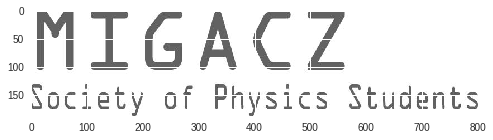

In [53]:
plt.imshow(img)